In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv("Tax Pricing Dataset V2.csv", delimiter=",")  # <-- delimiter added
print(data.columns)

Index(['clientid', 'jobid', 'WorkType', 'JobOffice', 'IndustryType',
       'JobPartnerName', 'Year', 'Hours', 'LaborCost', 'Production', 'Expense',
       'WO', 'NetProduction'],
      dtype='object')


In [4]:
# Define features
numerical_features = ['Hours', 'Production', 'LaborCost', 'Expense', 'WO', 'NetProduction']
categorical_features = ['clientid', 'jobid', 'Joboffice', 'IndustryType', 'WorkType', 'Year']


In [5]:
# for all the categorical columns, we can see the unique values
for col in data.select_dtypes(include='object').columns:
    print(f'{col}: {data[col].unique()}')

clientid: ['0000EB6A-527D-ED11-81AD-000D3A111BC4'
 '000A6A97-15E0-EC11-BB3D-002248326925'
 '000CBA4F-5A7D-ED11-81AD-000D3A111BC4' ...
 'FFC645FE-517D-ED11-81AD-000D3A111BC4'
 'FFC7392D-16E0-EC11-BB3D-002248326925'
 'FFD5074C-1741-ED11-9DB0-00224821E8CD']
jobid: ['9E3DADAE-2F78-EE11-8179-000D3A111BC4'
 'D9822503-F8ED-48B6-BBD6-3FA9D818FEEB'
 '75162684-3178-EE11-8179-000D3A111BC4' ...
 '09500E85-58B3-4A85-96D0-0A2D55EFA1C5'
 '17B4844C-667E-ED11-81AD-000D3A1125A2'
 '3E132C87-D011-EE11-8F6D-000D3A111BC4']
WorkType: ['051 1041 Tax Compliance' '050 1040 Tax Compliance'
 '085 1120S Tax Compliance' '056 1120 Tax Compliance'
 '055 1065 Tax Compliance' '058 990 Tax Compliance'
 '052 568 Tax Compliance' '054 Other Tax Compliance'
 '057 706 Tax Compliance' '088 709 Tax Compliance'
 '114 1042 Tax Compliance' "084 Inter'l Tax Compliance"
 '089 SALT Compliance' '057 706 Tax Compliance)']
JobOffice: ['NYM' 'OC' 'FL' 'MV' 'WW' 'Chi' 'NYLI' 'SAC' 'SR' 'SJ' 'NYC' 'CC '
 'CC AO' 'DM' 'LA' 'SF' 'WC' 'TX' '

In [6]:
data.describe(include='all')

,clientid,jobid,WorkType,JobOffice,IndustryType,JobPartnerName,Year,Hours,LaborCost,Production,Expense,WO,NetProduction
count,42292,42292,42292,42292,42284,42282,42292.000000,42292.000000,42292.000000,42292.000000,42292.000000,42292.000000,42292.000000
unique,13618,26679,14,23,32,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0C9810EB-18E0-EC11-BB3D-002248326925,5C21D2D0-1B78-EE11-8179-000D3A112AF7,050 1040 Tax Compliance,NYM,99-Individuals/Trusts/Estates,15BH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,200,21,17889,12063,22934,4056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2023.223021,9.411940,843.533929,3110.043889,42.066754,-817.185904,2334.924739
std,NaN,NaN,NaN,NaN,NaN,NaN,0.747122,30.190065,2783.269275,10360.217335,437.126648,3340.582207,9334.606064
min,NaN,NaN,NaN,NaN,NaN,NaN,2022.000000,-26.650000,-1640.024500,-6643.000000,-80.200000,-185996.520000,-185996.520000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2023.000000,0.133300,0.000000,31.000000,0.000000,-680.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2023.000000,2.100000,168.221000,716.000000,0.000000,-67.500000,590.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2024.000000,8.770775,752.627750,2813.087500,0.000000,0.000000,2288.375000


In [10]:
# 1. Define features
# -------------------------
numerical_features = ['Hours', 'Production', 'LaborCost', 'Expense', 'WO', 'NetProduction']
categorical_features = ['clientid', 'jobid', 'JobOffice', 'IndustryType', 'WorkType', 'Year']

# -------------------------
# 2. Ensure WorkType column exists
# -------------------------
if "WorkType" not in data.columns:
    print("⚠️ WorkType not found. Creating from mapping...")
    mapping = {
        "Trust": "051 1041 Tax Compliance",
        "Individual": "050 1040 Tax Compliance",
        "S Corp": "085 1120S Tax Compliance",
        "C Corp": "056 1120 Tax Compliance",
        "Partnerships": "055 1065 Tax Compliance",
        "NFP Returns": "058 990 Tax Compliance",
        "LLC Return": "052 568 Tax Compliance",
        "Other": "054 Other Tax Compliance",
        "706 Tax": "057 706 Tax Compliance",
        "709 Tax": "088 709 Tax Compliance",
        "1042 Tax": "114 1042 Tax Compliance",
        "International": "084 Inter'l Tax Compliance",
        "SALT Tax": "089 SALT Compliance"
    }
    data["WorkType"] = data["SomeColumn"].map(mapping).fillna("Other")  # replace SomeColumn with actual source column

# Create ReturnType column (to drive loop)
data["ReturnType"] = data["WorkType"]

# -------------------------
# 3. Regression per ReturnType
# -------------------------
results = {}

for rtype in data["ReturnType"].unique():
    subset = data[data["ReturnType"] == rtype]

    if subset.shape[0] < 30:  # skip small samples
        continue

    X = subset[numerical_features + categorical_features].copy()
    y = subset['NetProduction']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessor for each subset
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ]
    )

    regression_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

    regression_pipeline.fit(X_train, y_train)
    y_pred = regression_pipeline.predict(X_test)

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[rtype] = {"RMSE": rmse, "MAE": mae, "R2": r2}

# -------------------------
# 4. Display results
# -------------------------
print("Regression Results by Return Type:")
for rtype, metrics in results.items():
    print(f"{rtype}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, R²={metrics['R2']:.2f}")

Regression Results by Return Type:
051 1041 Tax Compliance: RMSE=0.05, MAE=0.03, R²=1.00
050 1040 Tax Compliance: RMSE=0.09, MAE=0.05, R²=1.00
085 1120S Tax Compliance: RMSE=0.20, MAE=0.10, R²=1.00
056 1120 Tax Compliance: RMSE=0.55, MAE=0.25, R²=1.00
055 1065 Tax Compliance: RMSE=0.27, MAE=0.11, R²=1.00
058 990 Tax Compliance: RMSE=0.05, MAE=0.02, R²=1.00
052 568 Tax Compliance: RMSE=0.08, MAE=0.05, R²=1.00
054 Other Tax Compliance: RMSE=0.30, MAE=0.16, R²=1.00
057 706 Tax Compliance: RMSE=0.05, MAE=0.04, R²=1.00
088 709 Tax Compliance: RMSE=0.52, MAE=0.23, R²=1.00


C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_DBSCAN'] = dbscan.fit_predict(X_num_scaled)


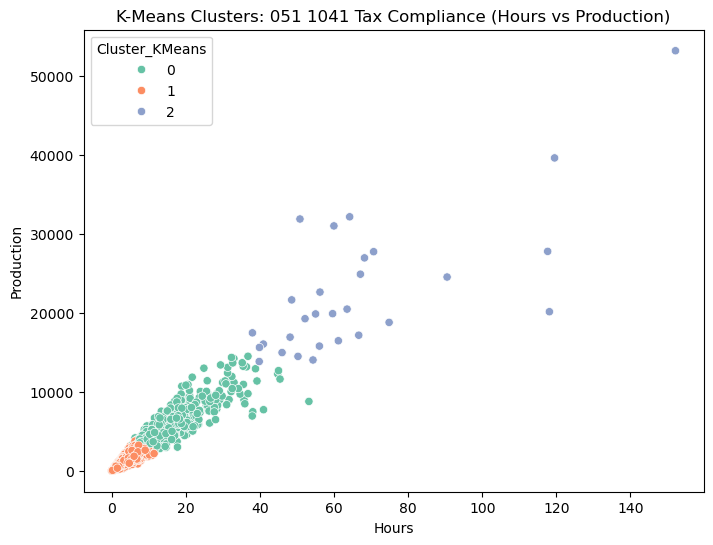

C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_DBSCAN'] = dbscan.fit_predict(X_num_scaled)


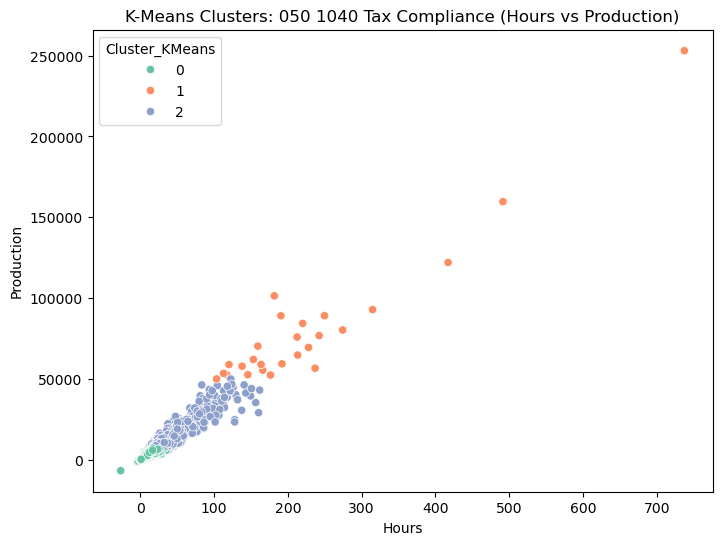

C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_DBSCAN'] = dbscan.fit_predict(X_num_scaled)


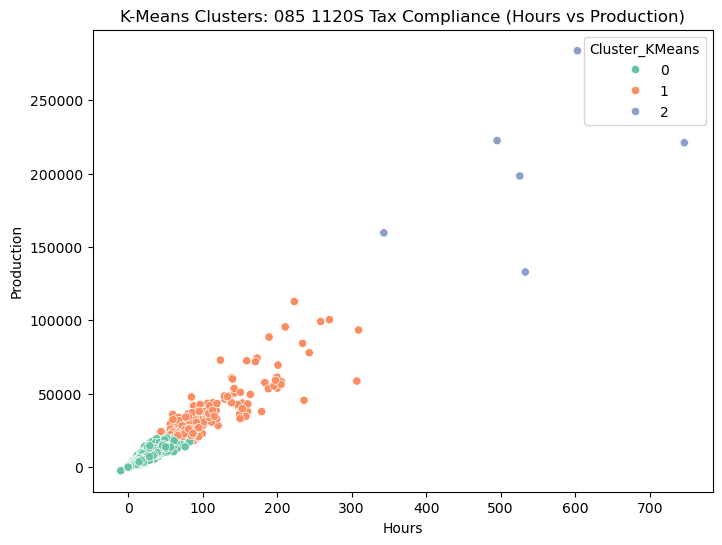

C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_DBSCAN'] = dbscan.fit_predict(X_num_scaled)


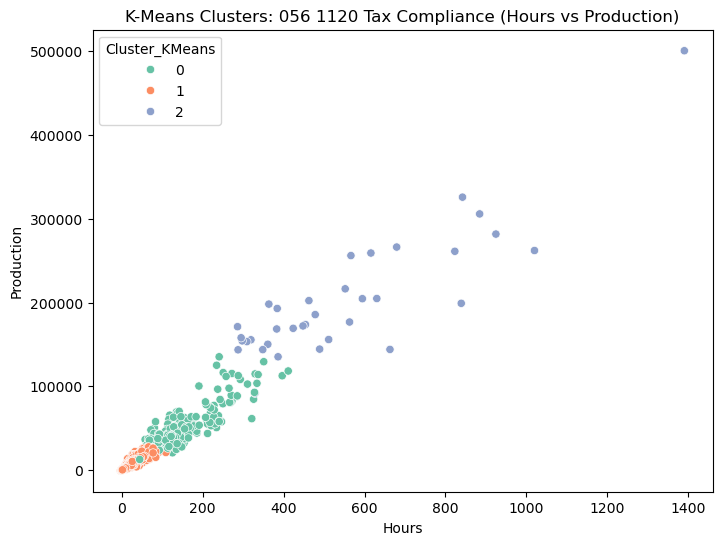

C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_DBSCAN'] = dbscan.fit_predict(X_num_scaled)


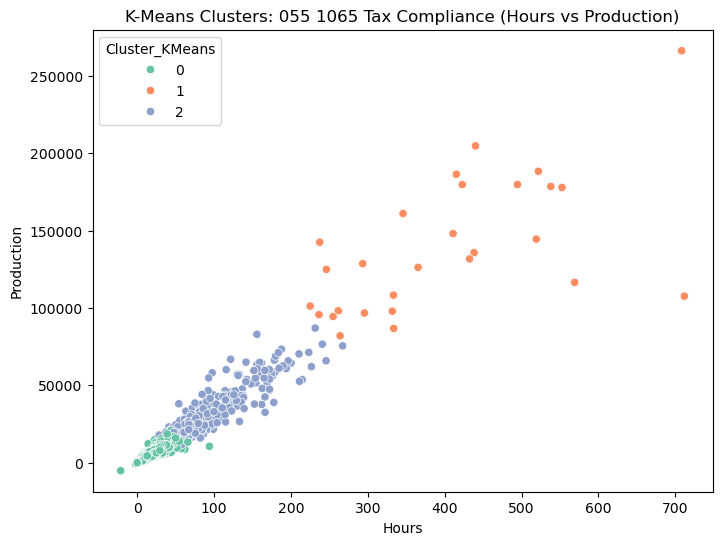

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

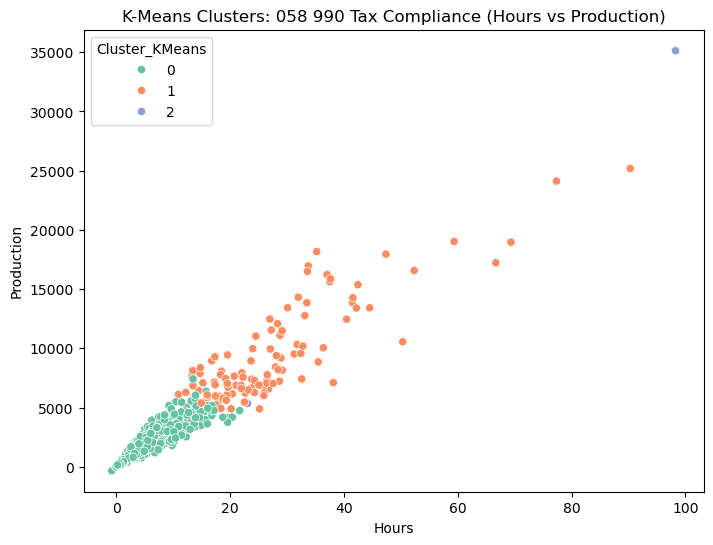

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

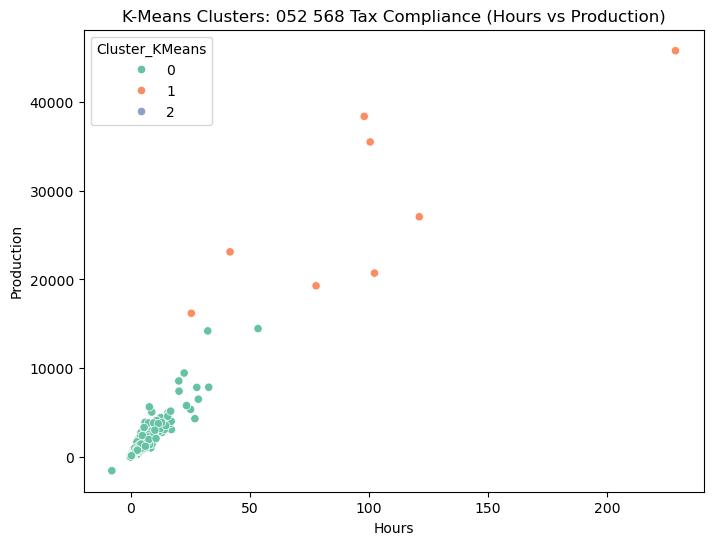

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

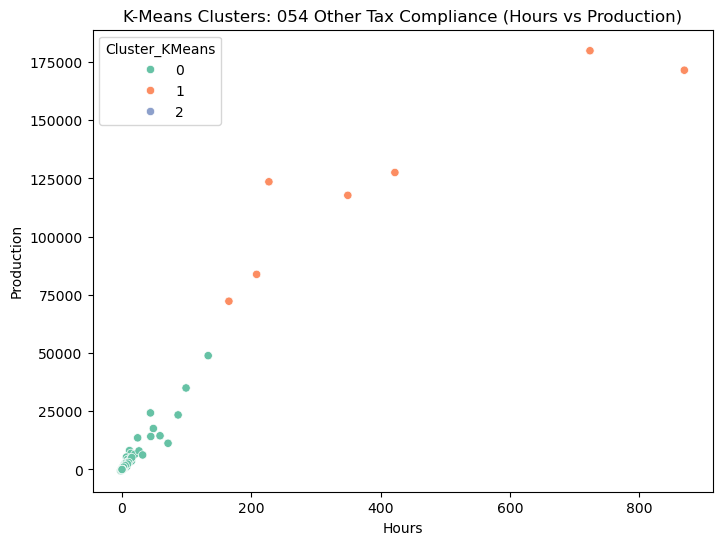

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

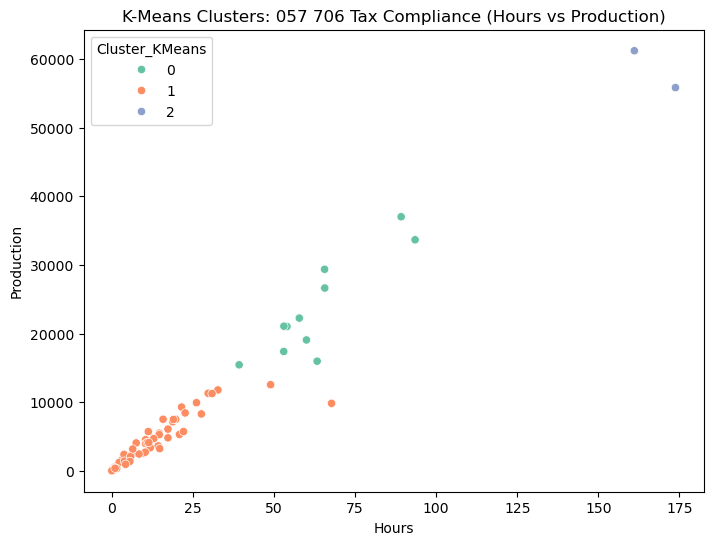

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)
C:\Users\FColon\AppData\Local\Temp\ipykernel_27720\54542360.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

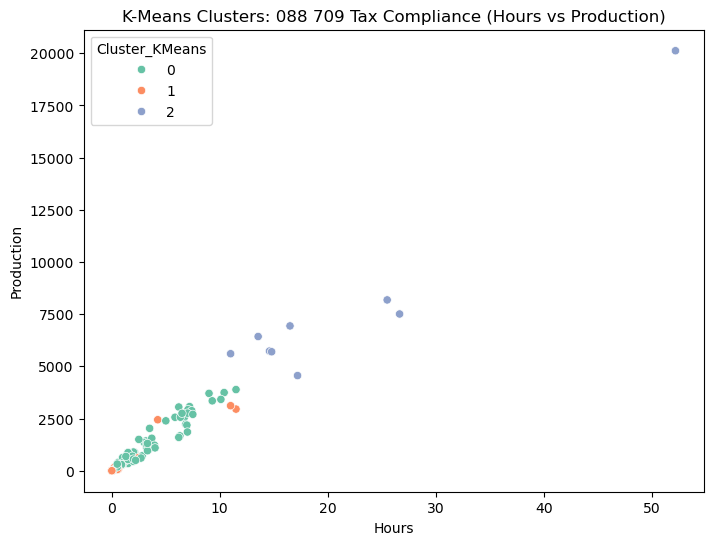

In [11]:
# 5. Clustering per ReturnType
# -------------------------
clustered_outputs = []

for rtype in data["ReturnType"].unique():
    subset = data[data["ReturnType"] == rtype]

    if subset.shape[0] < 30:  # skip small sample sets
        continue

    X_num_scaled = StandardScaler().fit_transform(subset[numerical_features])

    # KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    subset['Cluster_KMeans'] = kmeans.fit_predict(X_num_scaled)

    # DBSCAN
    dbscan = DBSCAN(eps=1.5, min_samples=5)
    subset['Cluster_DBSCAN'] = dbscan.fit_predict(X_num_scaled)

    # Save cluster results
    clustered_outputs.append(subset)

    # Visualization
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=subset['Hours'], y=subset['Production'], hue=subset['Cluster_KMeans'], palette='Set2')
    plt.title(f"K-Means Clusters: {rtype} (Hours vs Production)")
    plt.xlabel("Hours")
    plt.ylabel("Production")
    plt.show()

# -------------------------
# 6. Save all clustered data
# -------------------------
final_clustered_data = pd.concat(clustered_outputs, ignore_index=True)
final_clustered_data.to_csv("engagement_data_with_clusters_by_returntype.csv", index=False)

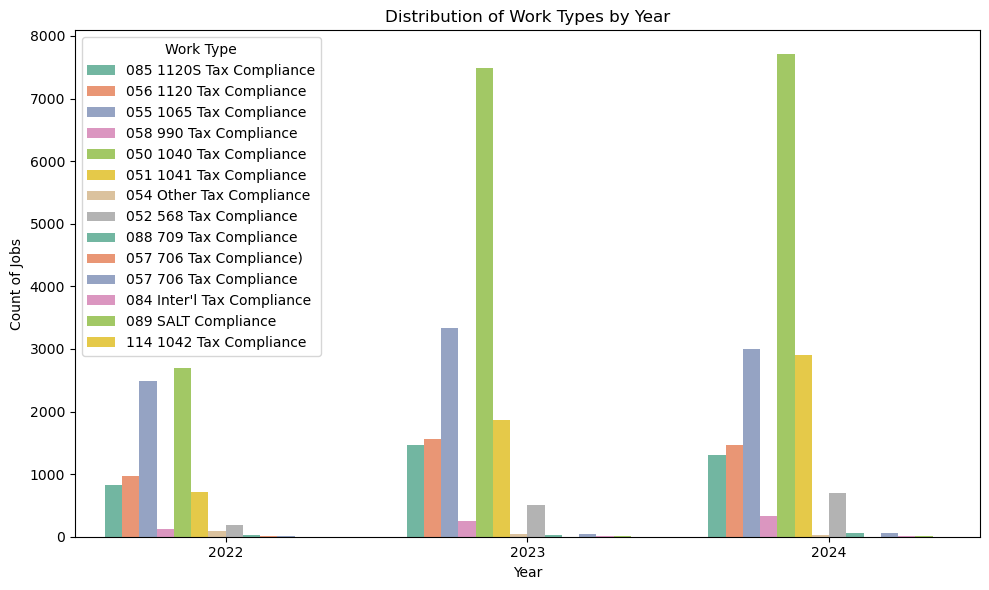

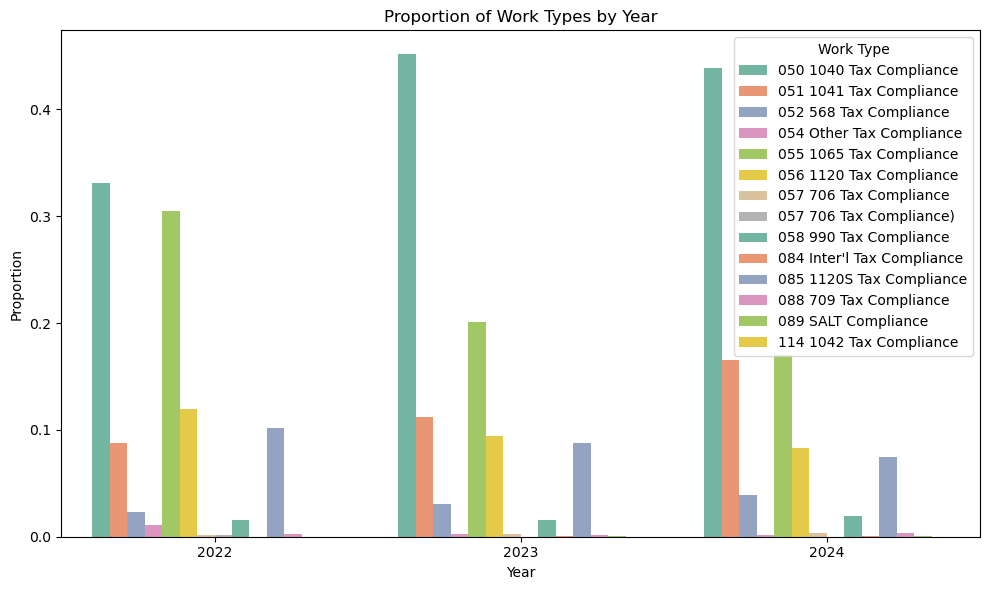

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# WorkType counts by Year
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="Year", hue="WorkType", palette="Set2")
plt.title("Distribution of Work Types by Year")
plt.xlabel("Year")
plt.ylabel("Count of Jobs")
plt.legend(title="Work Type")
plt.tight_layout()
plt.show()

# If you want proportions instead of counts:
worktype_year = data.groupby(["Year", "WorkType"]).size().reset_index(name="Count")
worktype_year["Proportion"] = worktype_year.groupby("Year")["Count"].transform(lambda x: x / x.sum())

plt.figure(figsize=(10, 6))
sns.barplot(data=worktype_year, x="Year", y="Proportion", hue="WorkType", palette="Set2")
plt.title("Proportion of Work Types by Year")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.legend(title="Work Type")
plt.tight_layout()
plt.show()

In [43]:
grouped = data.groupby('WorkType')[['Hours', 'Production', 'NetProduction', 'LaborCost', 'Expense']].mean().reset_index()
print(grouped)

                      WorkType      Hours    Production  NetProduction  \
0      050 1040 Tax Compliance   6.871792   2276.577102    1636.820941   
1      051 1041 Tax Compliance   3.979218   1350.930239    1078.366687   
2       052 568 Tax Compliance   2.011267    590.351367     446.671259   
3     054 Other Tax Compliance  26.654418   8161.154422    6280.949388   
4      055 1065 Tax Compliance  11.412136   3691.471564    2737.681045   
5      056 1120 Tax Compliance  21.356930   7229.566616    5748.864028   
6       057 706 Tax Compliance  15.287209   5372.751293    4448.533966   
7      057 706 Tax Compliance)   6.870000   2264.100000    2212.450000   
8       058 990 Tax Compliance   7.888167   2703.050014    2028.989848   
9   084 Inter'l Tax Compliance  28.764806   9608.208333    4298.437778   
10    085 1120S Tax Compliance  14.314067   4667.690123    3436.087156   
11      088 709 Tax Compliance   4.446825   1632.344762    1526.733238   
12         089 SALT Compliance  37.511

In [45]:
yearly_summary = data.groupby(['Year'])['NetProduction'].sum().reset_index()
print(yearly_summary)

   Year  NetProduction
0  2022   2.443366e+07
1  2023   3.940873e+07
2  2024   3.490624e+07


In [52]:
avg_prod_by_worktype = data.groupby('WorkType', as_index=False)['NetProduction'].mean()

C:\Users\FColon\AppData\Local\Temp\ipykernel_58012\4048896315.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_prod_by_worktype, x='WorkType', y='NetProduction', palette='coolwarm')


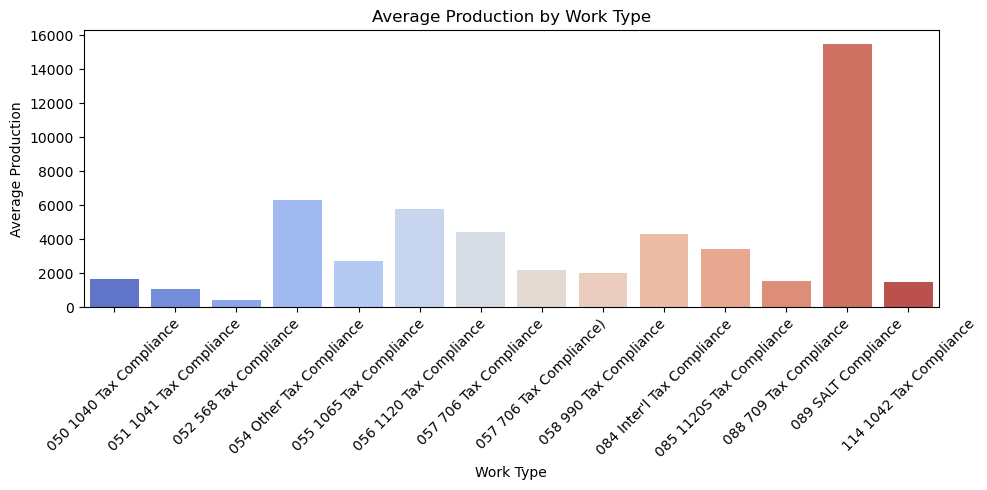

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=avg_prod_by_worktype, x='WorkType', y='NetProduction', palette='coolwarm')
plt.title('Average Production by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Average Production')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Columns: ['clientid', 'jobid', 'WorkType', 'JobOffice', 'IndustryType', 'JobPartnerName', 'Year', 'Hours', 'LaborCost', 'Production', 'Expense', 'WO', 'NetProduction']


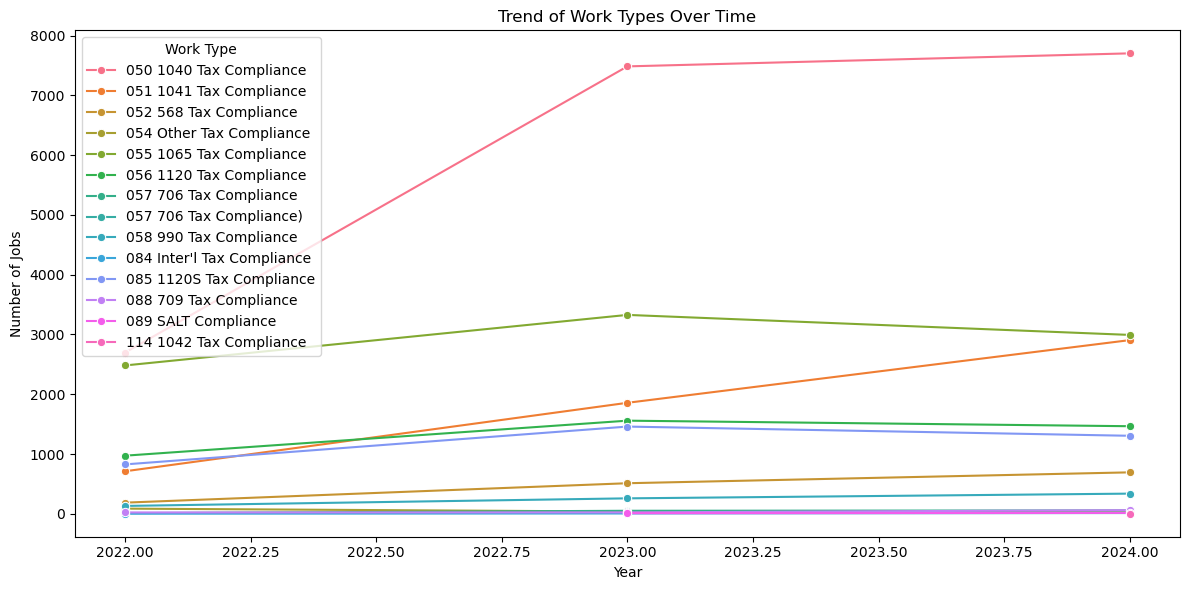

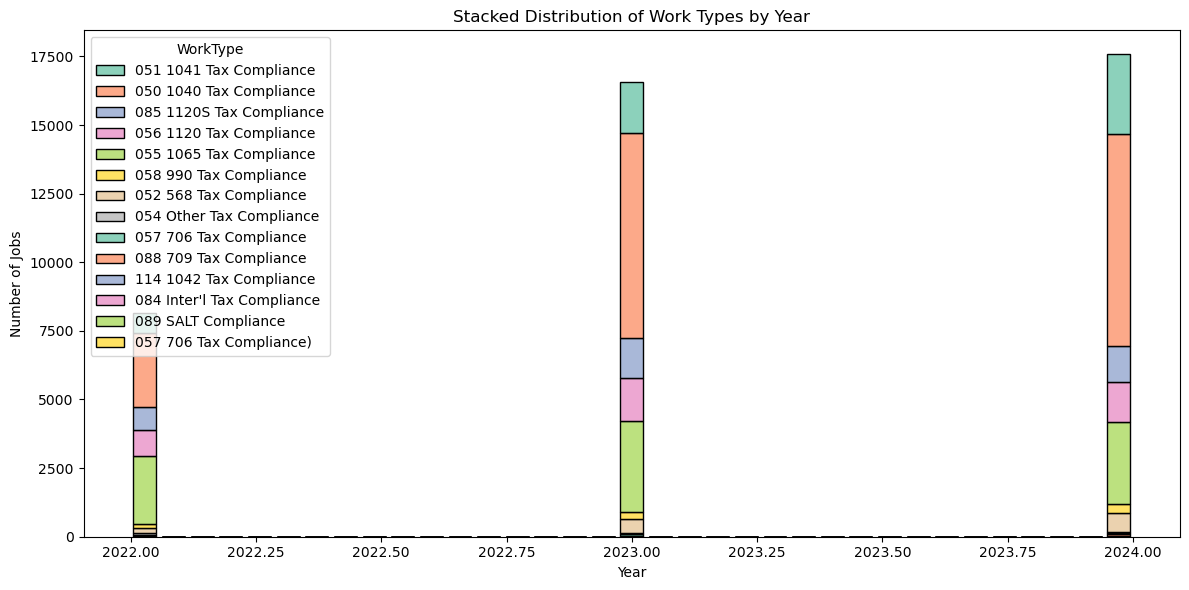

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Load data properly ---
data = pd.read_csv("Tax Pricing Dataset V2.csv", delimiter=",")  # ensure columns split
print("Columns:", data.columns.tolist())  # sanity check

# --- Aggregate counts of WorkType by Year ---
worktype_trend = (
    data.groupby(["Year", "WorkType"])
    .size()
    .reset_index(name="Count")
)

# --- Line chart: Volume of Work Types over Years ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=worktype_trend, x="Year", y="Count", hue="WorkType", marker="o")
plt.title("Trend of Work Types Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.legend(title="Work Type")
plt.tight_layout()
plt.show()

# --- Optional: Stacked bar (WorkType distribution each year) ---
plt.figure(figsize=(12, 6))
sns.histplot(
    data=data,
    x="Year",
    hue="WorkType",
    multiple="stack",
    palette="Set2",
    shrink=0.8
)
plt.title("Stacked Distribution of Work Types by Year")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.tight_layout()
plt.show()

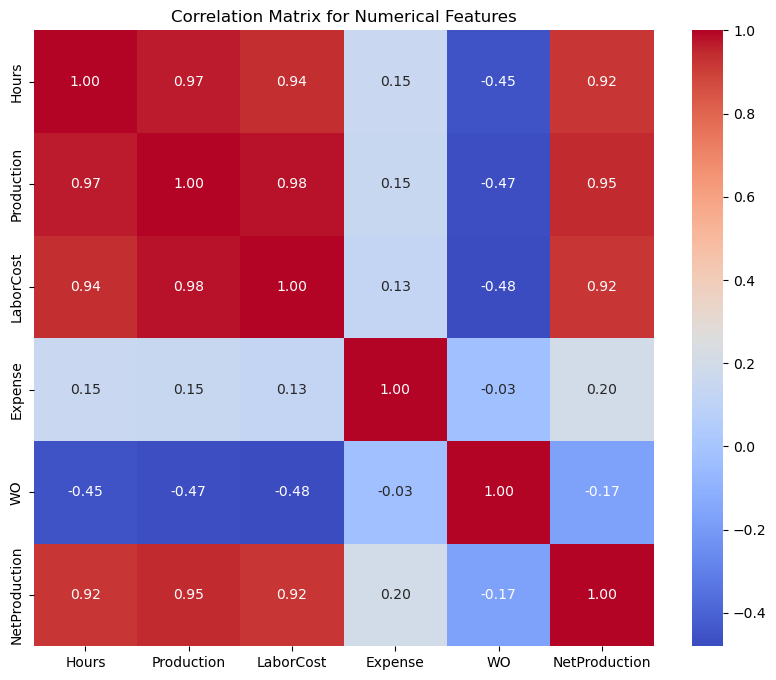

,Hours,Production,LaborCost,Expense,WO,NetProduction
Hours,1.000000,0.970008,0.939809,0.150500,-0.451685,0.921987
Production,0.970008,1.000000,0.979988,0.147982,-0.473951,0.947189
LaborCost,0.939809,0.979988,1.000000,0.132436,-0.480293,0.921980
Expense,0.150500,0.147982,0.132436,1.000000,-0.028793,0.200766
WO,-0.451685,-0.473951,-0.480293,-0.028793,1.000000,-0.169502
NetProduction,0.921987,0.947189,0.921980,0.200766,-0.169502,1.000000


In [55]:
# Calculate correlations for numerical features
correlation_matrix = data[numerical_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix for Numerical Features")
plt.show()

correlation_matrix

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import sys

# 1. Load the data
try:
    df = pd.read_csv('Tax Pricing Dataset V2.csv')
except FileNotFoundError:
    print("Error: 'Tax Pricing Dataset V2.csv' not found. Please provide a path to your data.")
    sys.exit(1)

# Preview data
print("Initial Data Preview:")
print(df.head())

# 2. Define features and target variable
numerical_features = ['Hours', 'Production', 'LaborCost', 'Expense', 'WO']
categorical_features = ['clientid', 'jobid', 'JobOffice', 'IndustryType', 'WorkType', 'Year']
target_variable = 'NetProduction'   # ✅ new target

# Ensure target exists
if target_variable not in df.columns:
    raise ValueError(f"Target variable '{target_variable}' not found in dataset.")

# Ensure selected features exist in dataset
missing_features = set(numerical_features + categorical_features) - set(df.columns)
if missing_features:
    raise ValueError(f"Missing features in dataset: {missing_features}")

# 3. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 4. Model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 5. Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

# 6. Split data
X = df[numerical_features + categorical_features]
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining model...")
pipeline.fit(X_train, y_train)
print("Model training complete.")

# 7. Evaluation
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

# 8. New prediction example
new_data = pd.DataFrame([{
    'Hours': 10,
    'Production': 1000,
    'LaborCost': 500,
    'Expense': 50,
    'WO': 20,
    'clientid': 'client_A',
    'jobid': 'job_123',
    'JobOffice': 'Office_A',
    'IndustryType': 'Industry_X',
    'WorkType': 'Type_C',
    'Year': 2025
}])

new_prediction = pipeline.predict(new_data)
print("\nNew Data Prediction:")
print(f"Predicted NetProduction: {new_prediction[0]:.2f}")

# 9. Feature importance extraction
# Get feature names after preprocessing
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_features)

all_feature_names = numerical_features + list(encoded_cat_features)

importances = pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop Feature Importances:")
print(feature_importance_df.head(15))

Initial Data Preview:
                               clientid                                 jobid  \
0  0000EB6A-527D-ED11-81AD-000D3A111BC4  9E3DADAE-2F78-EE11-8179-000D3A111BC4   
1  0000EB6A-527D-ED11-81AD-000D3A111BC4  D9822503-F8ED-48B6-BBD6-3FA9D818FEEB   
2  000A6A97-15E0-EC11-BB3D-002248326925  75162684-3178-EE11-8179-000D3A111BC4   
3  000A6A97-15E0-EC11-BB3D-002248326925  A03A19EC-3B78-EE11-8179-000D3A1125A2   
4  000A6A97-15E0-EC11-BB3D-002248326925  A6B3D034-2878-EE11-8179-000D3A112566   

                   WorkType JobOffice                           IndustryType  \
0   051 1041 Tax Compliance       NYM          99-Individuals/Trusts/Estates   
1   051 1041 Tax Compliance       NYM          99-Individuals/Trusts/Estates   
2   050 1040 Tax Compliance        OC  52-Finance and Insurance - Holding Co   
3   050 1040 Tax Compliance        OC  52-Finance and Insurance - Holding Co   
4  085 1120S Tax Compliance        OC  52-Finance and Insurance - Holding Co   

  JobPartn

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


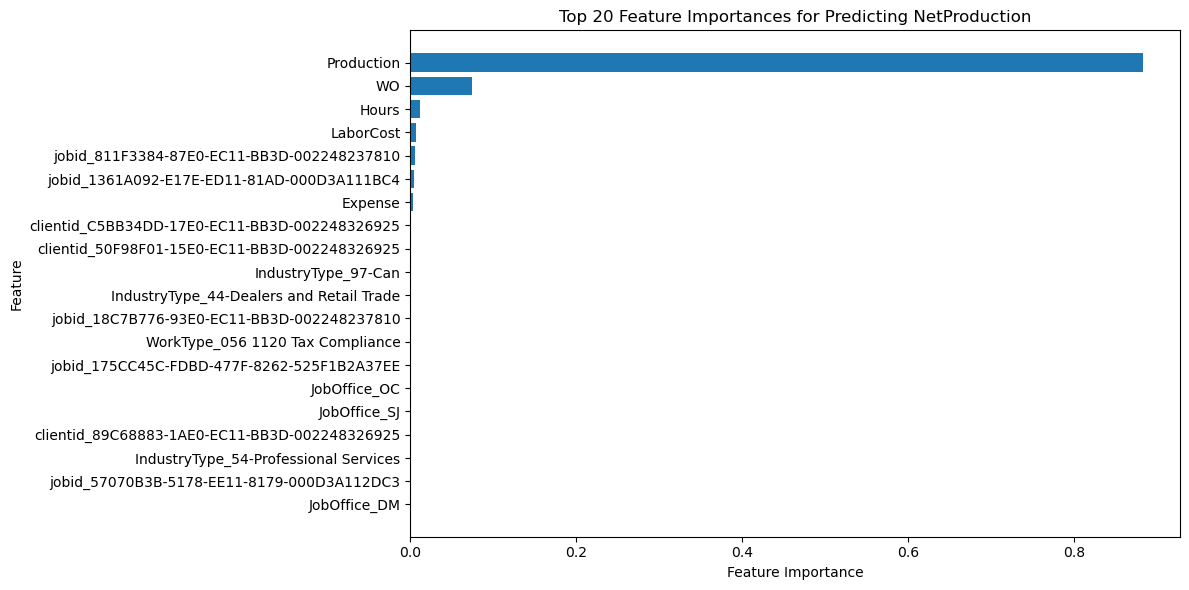

In [70]:
# 10. Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'].head(20), feature_importance_df['Importance'].head(20))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances for Predicting NetProduction")
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

✅ Analyzing ReturnType: 0         051 1041 Tax Compliance
1         051 1041 Tax Compliance
2         050 1040 Tax Compliance
3         050 1040 Tax Compliance
4        085 1120S Tax Compliance
                   ...           
42287     051 1041 Tax Compliance
42288     056 1120 Tax Compliance
42289     050 1040 Tax Compliance
42290     050 1040 Tax Compliance
42291     050 1040 Tax Compliance
Name: ReturnType, Length: 42292, dtype: object
⚠️ 'Cluster_KMeans' column not found in dataset – skipping cluster plot.


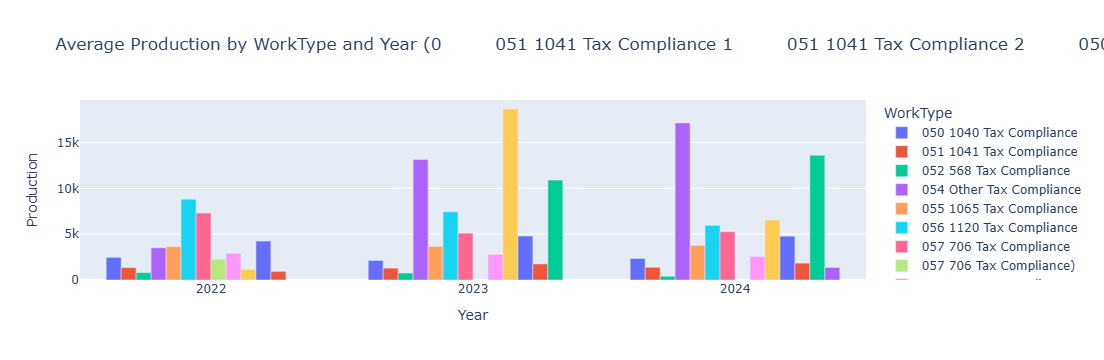

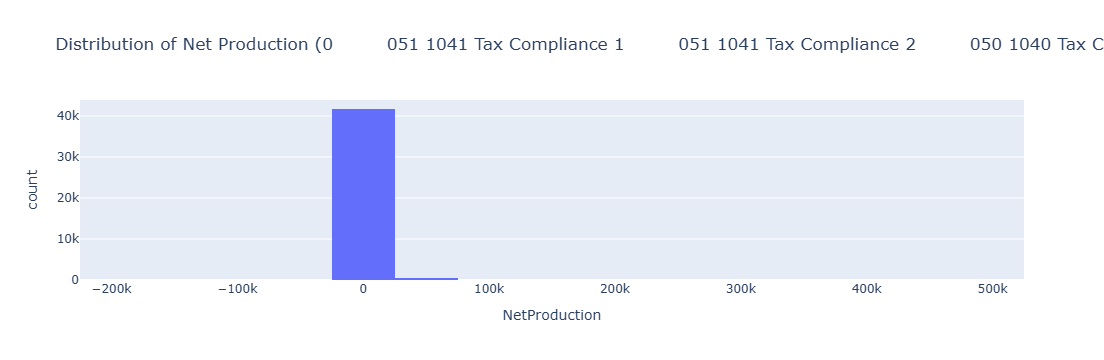

In [24]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 1. Load clustered + regression data
# -------------------------------------------------
data = pd.read_csv("Tax Pricing Dataset V2.csv", delimiter=",")

# -------------------------------------------------
# 2. Ensure WorkType exists (map if missing)
# -------------------------------------------------
if "WorkType" not in data.columns:
    print("⚠️ WorkType not found. Creating from mapping...")
    mapping = {
        "Trust": "051 1041 Tax Compliance",
        "Individual": "050 1040 Tax Compliance",
        "S Corp": "085 1120S Tax Compliance",
        "C Corp": "056 1120 Tax Compliance",
        "Partnerships": "055 1065 Tax Compliance",
        "NFP Returns": "058 990 Tax Compliance",
        "LLC Return": "052 568 Tax Compliance",
        "Other": "054 Other Tax Compliance",
        "706 Tax": "057 706 Tax Compliance",
        "709 Tax": "088 709 Tax Compliance",
        "1042 Tax": "114 1042 Tax Compliance",
        "International": "084 Inter'l Tax Compliance",
        "SALT Tax": "089 SALT Compliance"
    }
    # Replace 'SomeColumn' with the real column to map from
    if "ReturnCategory" in data.columns:
        data["WorkType"] = data["ReturnCategory"].map(mapping).fillna("Other")
    else:
        data["WorkType"] = "Other"

# Create ReturnType column (alias of WorkType)
data["ReturnType"] = data["WorkType"]

# -------------------------------------------------
# 3. Choose a ReturnType to analyze
# -------------------------------------------------
selected_rtype = data["ReturnType"]
subset = data[data["ReturnType"] == selected_rtype]

print(f"✅ Analyzing ReturnType: {selected_rtype}")

# -------------------------------------------------
# 4. Graph 1: Cluster visualization (Hours vs Production)
# -------------------------------------------------
if "Cluster_KMeans" in subset.columns:
    fig1 = px.scatter(
        subset, x="Hours", y="Production",
        color="Cluster_KMeans",
        hover_data=["clientid", "jobid", "NetProduction"],
        title=f"K-Means Clusters – {selected_rtype} (Hours vs Production)"
    )
    fig1.show()
else:
    print("⚠️ 'Cluster_KMeans' column not found in dataset – skipping cluster plot.")

# -------------------------------------------------
# 5. Graph 2: Average Production by WorkType and Year
# -------------------------------------------------
if {"Year", "WorkType", "Production"}.issubset(subset.columns):
    avg_by_year = subset.groupby(["Year", "WorkType"])["Production"].mean().reset_index()
    fig2 = px.bar(
        avg_by_year, x="Year", y="Production", color="WorkType",
        barmode="group",
        title=f"Average Production by WorkType and Year ({selected_rtype})"
    )
    fig2.show()
else:
    print("⚠️ Missing columns for 'Average Production by WorkType and Year'.")

# -------------------------------------------------
# 6. Graph 3: Distribution of Net Production
# -------------------------------------------------
if "NetProduction" in subset.columns:
    fig3 = px.histogram(
        subset, x="NetProduction", nbins=30,
        title=f"Distribution of Net Production ({selected_rtype})"
    )
    fig3.show()
else:
    print("⚠️ 'NetProduction' column not found in dataset – skipping histogram.")